In [1]:
import numpy as np, pandas as pd
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_history(history, epochs):
    sns.set()
    fig, ax = plt.subplots(1,1, figsize=(12, 4))
    ax.plot(range(epochs), history.history['loss'], label="train")
    ax.plot(range(epochs), history.history['val_loss'], label="val")
    ax.legend()
    ax.set_title("RMSE")
    #ax[0].axis((30, 200, 90, 95))

In [3]:
base_dir = "../input/beyond-analysis/"

In [4]:
# Load train and test sets
train = pd.read_csv(base_dir + "train.csv")
test = pd.read_csv(base_dir + "test.csv")

In [5]:
def unique_len(series):
    return len(series.unique())

def deviation(series, mean):
    return np.square(series.mean()-mean)

In [6]:
def calc_customer_stats(df):
    entry_mean = df['ENTRY'].mean()
    revenue_mean = df['REVENUE'].mean()
    winnings_1 = df['WINNINGS_1'].mean()
    discount_mean = df['DISCOUNT'].mean()
    deposit_mean = df['DEPOSIT'].mean()
    deposit_numer_mean = df['DEPOSIT_NUMBER'].mean()
    deposit_2_mean = df['DEPOSIT_2'].mean()
    deposit_trials_mean = df['DEPOSIT_TRAILS'].mean()
    entry_number_mean = df['ENTRY_NUMBER'].mean()
    winning_number_mean = df['WINNINGS_NUMBER'].mean()
    agg_dict = {
        "ENTRY": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, entry_mean)],
        "REVENUE": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, revenue_mean)],
        "WINNINGS_1": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, winnings_1)],
        "WINNINGS_2": ["mean","sum", np.std],
        "DISCOUNT": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, discount_mean)],
        "DEPOSIT": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, deposit_mean)],
        "DEPOSIT_NUMBER": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, deposit_numer_mean)],
        "DEPOSIT_2": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, deposit_2_mean)],
        "WITHDRAW": ["mean","sum", np.std],
        "WITHDRAW_NUMBER": ["mean","sum", np.std],
        "DEPOSIT_TRAILS": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, deposit_trials_mean)],
        "ENTRY_NUMBER": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, entry_number_mean)],
        "WINNINGS_NUMBER": ["mean","sum", np.std, "max", "min", unique_len, lambda x: deviation(x, winning_number_mean)],
        "PRACTICE_ENTRY": ["mean","sum", unique_len],
        "PRACTICE_WINNINGS": ["mean","sum", unique_len],
        "PRACTICE_ENTRY_NUMBER": ["mean","sum", unique_len],
        "PRACTICE_WINNINGS_NUMBER": ["mean","sum", unique_len]
    }
    
    df_grp = df.groupby("UNIQUE_IDENTIFIER").agg(agg_dict)
    df_grp.columns = ["_".join(col) for col in df_grp.columns]
    df_grp = df_grp.reset_index()
    return df_grp

If using boosting then go down from here to LightGBM...

In [7]:
# preprocess train data
train_ = calc_customer_stats(train)
temp = train.groupby("UNIQUE_IDENTIFIER")[["Y1","Y2"]].agg(lambda x: x.unique()[0]).reset_index()
train_ = train_.merge(temp, on="UNIQUE_IDENTIFIER", how="left")

In [8]:
# Preprocess test data
test_ = calc_customer_stats(test)

In [9]:
# Fill NaN values which are zero std
train_ = train_.fillna(value=0)
test_ = test_.fillna(value=0)

In [10]:
train_

,UNIQUE_IDENTIFIER,ENTRY_mean,ENTRY_sum,ENTRY_std,ENTRY_max,ENTRY_min,ENTRY_unique_len,ENTRY_<lambda_0>,REVENUE_mean,REVENUE_sum,REVENUE_std,REVENUE_max,REVENUE_min,REVENUE_unique_len,REVENUE_<lambda_0>,WINNINGS_1_mean,WINNINGS_1_sum,WINNINGS_1_std,WINNINGS_1_max,WINNINGS_1_min,WINNINGS_1_unique_len,WINNINGS_1_<lambda_0>,WINNINGS_2_mean,WINNINGS_2_sum,WINNINGS_2_std,DISCOUNT_mean,DISCOUNT_sum,DISCOUNT_std,DISCOUNT_max,DISCOUNT_min,DISCOUNT_unique_len,DISCOUNT_<lambda_0>,DEPOSIT_mean,DEPOSIT_sum,DEPOSIT_std,DEPOSIT_max,DEPOSIT_min,DEPOSIT_unique_len,DEPOSIT_<lambda_0>,DEPOSIT_NUMBER_mean,DEPOSIT_NUMBER_sum,DEPOSIT_NUMBER_std,DEPOSIT_NUMBER_max,DEPOSIT_NUMBER_min,DEPOSIT_NUMBER_unique_len,DEPOSIT_NUMBER_<lambda_0>,DEPOSIT_2_mean,DEPOSIT_2_sum,DEPOSIT_2_std,DEPOSIT_2_max,DEPOSIT_2_min,DEPOSIT_2_unique_len,DEPOSIT_2_<lambda_0>,WITHDRAW_mean,WITHDRAW_sum,WITHDRAW_std,WITHDRAW_NUMBER_mean,WITHDRAW_NUMBER_sum,WITHDRAW_NUMBER_std,DEPOSIT_TRAILS_mean,DEPOSIT_TRAILS_sum,DEPOSIT_TRAILS_std,DEPOSIT_TRAILS_max,DEPOSIT_TRAILS_min,DEPOSIT_TRAILS_unique_len,DEPOSIT_TRAILS_<lambda_0>,ENTRY_NUMBER_mean,ENTRY_NUMBER_sum,ENTRY_NUMBER_std,ENTRY_NUMBER_max,ENTRY_NUMBER_min,ENTRY_NUMBER_unique_len,ENTRY_NUMBER_<lambda_0>,WINNINGS_NUMBER_mean,WINNINGS_NUMBER_sum,WINNINGS_NUMBER_std,WINNINGS_NUMBER_max,WINNINGS_NUMBER_min,WINNINGS_NUMBER_unique_len,WINNINGS_NUMBER_<lambda_0>,PRACTICE_ENTRY_mean,PRACTICE_ENTRY_sum,PRACTICE_ENTRY_unique_len,PRACTICE_WINNINGS_mean,PRACTICE_WINNINGS_sum,PRACTICE_WINNINGS_unique_len,PRACTICE_ENTRY_NUMBER_mean,PRACTICE_ENTRY_NUMBER_sum,PRACTICE_ENTRY_NUMBER_unique_len,PRACTICE_WINNINGS_NUMBER_mean,PRACTICE_WINNINGS_NUMBER_sum,PRACTICE_WINNINGS_NUMBER_unique_len,Y1,Y2
0,98481267304,0.112236,0.785650,0.161104,0.444900,0.00000,5.0,21.293467,0.008682,0.060775,0.012964,0.035850,0.000000,5.0,0.277022,0.052929,0.37050,0.089910,0.2398,0.000,5.0,13.306997,0.000000,0.0000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.200944,0.035714,0.25,0.094491,0.25,0.0,2.0,0.525017,0.014286,0.1,0.037796,0.1,0.0,2.0,6.298383e-04,0.035714,0.25,0.094491,0.25,0.0,2.0,0.004277,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.0,1.0,0.019017,0.928571,6.5,1.060997,2.8,0.0,6.0,1.794764,0.442857,3.1,0.585540,1.5,0.0,4.0,0.089195,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,1.0,4.449287,101.369863
1,98481267698,30.285742,575.429100,23.928169,73.000000,0.00000,18.0,653.263600,3.733455,70.935650,2.877883,8.800000,0.000000,19.0,10.230045,25.120618,477.29175,29.067517,96.8000,0.000,13.0,458.808440,0.000000,0.0000,0.000000,1.163158,22.1,2.758665,12.0,0.0,7.0,0.511067,10.263158,195.00,15.676742,50.00,0.0,6.0,90.304405,0.052632,1.0,0.069669,0.2,0.0,3.0,1.755436e-04,0.526316,10.00,2.294157,10.00,0.0,2.0,0.180797,1.357895,25.8,4.705826,0.010526,0.2,0.03153,0.684211,13.0,1.945154,8.0,0.0,4.0,0.298453,0.700000,13.3,0.838650,3.7,0.0,10.0,2.459438,0.247368,4.7,0.347001,1.4,0.0,7.0,0.244179,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,1.0,7.182779,115.068493
2,98481269325,0.083720,1.506960,0.161723,0.492110,0.00000,7.0,21.557451,0.007540,0.135719,0.015349,0.048498,0.000000,7.0,0.278226,0.052828,0.95090,0.094959,0.3153,0.000,6.0,13.307732,0.000000,0.0000,0.000000,0.033333,0.6,0.102899,0.4,0.0,3.0,0.172171,0.013889,0.25,0.058926,0.25,0.0,2.0,0.557122,0.005556,0.1,0.023570,0.1,0.0,2.0,1.144248e-03,0.013889,0.25,0.058926,0.25,0.0,2.0,0.007608,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.027778,0.5,0.117851,0.5,0.0,2.0,0.012127,1.311111,23.6,2.583406,9.4,0.0,6.0,0.916133,0.305556,5.5,0.585584,2.1,0.0,6.0,0.190059,0.000000,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,1.0,3.977371,24.657534
3,98481271512,0.777000,3.885000,1.490225,3.435000,0.00000,4.0,15.600290,0.122220,0.611100,0.234841,0.541100,0.000000,4.0,0.170396,0.017000,0.08500,0.038013,0.0850,0.000,2.0,13.570414,0.000000,0.0000,0.000000,0.240000,1.2,0.536656,1.2,0.0,2.0,0.043376,0.700000,3.50,1.095445,2.50,0.0,3.0,0.003635,0.040000,0.2,0.054772,0.1,0.0,2.0,3.815620e-07,0.200000,1.00

In [11]:
print(train_.shape, test_.shape)

(96298, 94) (65242, 92)


# Model

## DNN

In [12]:
X = train_.drop(['UNIQUE_IDENTIFIER', 'Y1', 'Y2'], axis=1)
y = train_[["Y1", "Y2"]]
X_test = test_.drop(["UNIQUE_IDENTIFIER"], axis=1)

In [13]:
# Update to the latest version
!pip install tensorflow

     |████████████████████████████████| 458.3 MB 10 kB/s 
     |████████████████████████████████| 5.6 MB 48.3 MB/s 
     |████████████████████████████████| 4.0 MB 62.9 MB/s 
     |████████████████████████████████| 4.3 MB 29.2 MB/s 
     |████████████████████████████████| 1.3 MB 51.8 MB/s 
     |████████████████████████████████| 462 kB 51.5 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30702 sha256=1fccc176a768145b0807eadf09d722a3e3d93382ba4b1d458f915318bf034652
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
Successfully built clang
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attemptin

In [14]:
!pip install -q -U keras-tuner

In [15]:
import keras_tuner as kt

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(16, input_shape=(X.shape[1], ), activation='relu'))
    
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units1', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
  # Tune the dropout values
  # Choose an optimal value between 0.1-0.5
  hp_units = hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.01)
  model.add(keras.layers.Dropout(hp_units))

  hp_units = hp.Int('units2', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))

  hp_units = hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.01)
  model.add(keras.layers.Dropout(hp_units))

  model.add(keras.layers.Dense(2))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    
  # Custom loss function
  def root_mean_squared_error(y_true, y_pred):
      return K.sqrt(K.mean(K.square(y_pred - y_true))) 

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=root_mean_squared_error)

  return model

In [17]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     directory='./',
                     project_name='kt_tuner')

In [18]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [19]:
tuner.search(X, y, epochs=100, validation_split=0.2, callbacks=[stop_early])

Trial 30 Complete [00h 01m 40s]
val_loss: 93.24654388427734

Best val_loss So Far: 87.6867904663086
Total elapsed time: 00h 22m 35s


In [20]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X, y, epochs=100, validation_split=0.2, verbose=1)

Epoch 1/100
2408/2408 [==============================] - 5s 2ms/step - loss: 103.7898 - val_loss: 90.3172
Epoch 2/100
2408/2408 [==============================] - 4s 2ms/step - loss: 93.0333 - val_loss: 89.0936
Epoch 3/100
2408/2408 [==============================] - 5s 2ms/step - loss: 92.0580 - val_loss: 89.2140
Epoch 4/100
2408/2408 [==============================] - 4s 2ms/step - loss: 91.7902 - val_loss: 89.8112
Epoch 5/100
2408/2408 [==============================] - 4s 2ms/step - loss: 91.2934 - val_loss: 88.8009
Epoch 6/100
2408/2408 [==============================] - 5s 2ms/step - loss: 91.1786 - val_loss: 88.9852
Epoch 7/100
2408/2408 [==============================] - 5s 2ms/step - loss: 90.6709 - val_loss: 88.3404
Epoch 8/100
2408/2408 [==============================] - 5s 2ms/step - loss: 90.9148 - val_loss: 88.3652
Epoch 9/100
2408/2408 [==============================] - 4s 2ms/step - loss: 90.7053 - val_loss: 89.9514
Epoch 10/100
2408/2408 [==============================

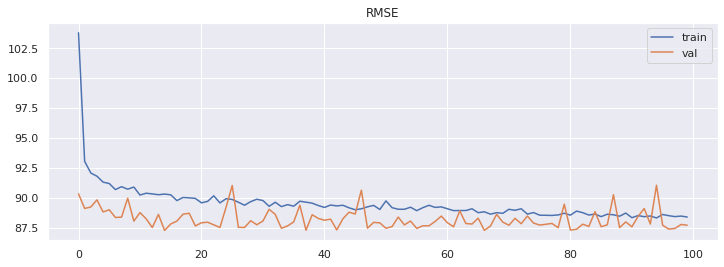

In [21]:
plot_history(history, 100)

In [22]:
val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 15


In [23]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X, y, epochs=best_epoch, validation_split=0.2)

Epoch 1/15
2408/2408 [==============================] - 6s 2ms/step - loss: 108.0674 - val_loss: 91.8209
Epoch 2/15
2408/2408 [==============================] - 4s 2ms/step - loss: 92.4249 - val_loss: 88.9036
Epoch 3/15
2408/2408 [==============================] - 4s 2ms/step - loss: 92.1284 - val_loss: 89.3496
Epoch 4/15
2408/2408 [==============================] - 5s 2ms/step - loss: 91.3191 - val_loss: 89.3038
Epoch 5/15
2408/2408 [==============================] - 5s 2ms/step - loss: 91.2687 - val_loss: 88.1909
Epoch 6/15
2408/2408 [==============================] - 5s 2ms/step - loss: 90.9667 - val_loss: 88.3108
Epoch 7/15
2408/2408 [==============================] - 6s 2ms/step - loss: 90.7456 - val_loss: 87.9349
Epoch 8/15
2408/2408 [==============================] - 5s 2ms/step - loss: 90.6625 - val_loss: 87.4945
Epoch 9/15
2408/2408 [==============================] - 4s 2ms/step - loss: 90.7690 - val_loss: 89.8204
Epoch 10/15
2408/2408 [==============================] - 4s 2ms

In [24]:
y_pred = hypermodel.predict(X_test)

In [25]:
test_["Y1_NN"] = y_pred[:,0]
test_["Y2_NN"] = y_pred[:,1]
test_[["UNIQUE_IDENTIFIER","Y1_NN","Y2_NN"]].to_csv("submission_NN.csv", index=False)

## LightGBM

In [26]:
import lightgbm as lgb
from lightgbm import plot_importance
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
seed = 21
np.random.seed(seed)

In [27]:
# preprocess train data
train_ = calc_customer_stats(train)
temp = train.groupby("UNIQUE_IDENTIFIER")[["STATUS_CHECK", "CATEGORY_1","CATEGORY_2","Y1","Y2"]].agg(lambda x: x.unique()[0]).reset_index()
train_ = train_.merge(temp, on="UNIQUE_IDENTIFIER", how="left")

In [28]:
# Preprocess test data
test_ = calc_customer_stats(test)
temp = test.groupby("UNIQUE_IDENTIFIER")[["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"]].agg(lambda x: x.unique()[0]).reset_index()
test_ = test_.merge(temp, on="UNIQUE_IDENTIFIER", how="left")

In [29]:
# Fill NaN values which are zero std
train_ = train_.fillna(value=0)
test_ = test_.fillna(value=0)

In [30]:
X = train_.drop(['UNIQUE_IDENTIFIER', 'Y1', 'Y2'], axis=1)
y = train_[["Y1", "Y2"]]
X_test = test_.drop(["UNIQUE_IDENTIFIER"], axis=1)

In [31]:
print(X.shape, X_test.shape)

(96298, 94) (65242, 94)


In [32]:
from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
le2 = LabelEncoder()
X_test['CATEGORY_1'] = le1.fit_transform(X_test['CATEGORY_1'])
X_test['CATEGORY_2'] = le2.fit_transform(X_test['CATEGORY_2'])
X['CATEGORY_1'] = le1.transform(X['CATEGORY_1'])
X['CATEGORY_2'] = le2.transform(X['CATEGORY_2'])

If using catboost then go down from here...

In [33]:
FOLDS = 5
lgb_params1 = {'bagging_fraction': 0.7446132365786178,
               'bagging_freq': int(94.57044996418587),
               'feature_fraction': 0.9012097906532421,
               'feature_fraction_bynode': 0.2724293678054648,
               'lambda_l1': 6.697079462213692,
               'lambda_l2': 0.05709330859845584,
               'learning_rate': 0.17588487226531224,
               'min_data_in_leaf': int(154.15270440199714),
               'min_sum_hessian_in_leaf': 58.37985742493366,
               'num_leaves': int(622.1019844986934),
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1
}

lgb_params2 = {'bagging_fraction': 0.8251097530764318,
               'bagging_freq': int(30.596065567048885),
               'feature_fraction': 0.49998711057091194,
               'feature_fraction_bynode': 0.8507173745725533,
               'lambda_l1': 7.555927148134436,
               'lambda_l2': 7.988171568347725,
               'learning_rate': 0.054902068760180736,
               'min_data_in_leaf': int(797.5794978618343),
               'min_sum_hessian_in_leaf': 18.06814076686615,
               'num_leaves': int(529.4188648232011),
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1}

########################################
Training Fold -  1
####################
Training for Y1
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 5.58455	validation's rmse: 6.18099
[400]	training's rmse: 4.73002	validation's rmse: 6.31359
[600]	training's rmse: 4.0722	validation's rmse: 6.51297
[800]	training's rmse: 3.48389	validation's rmse: 6.59034
[1000]	training's rmse: 3.12223	validation's rmse: 6.62645
Early stopping, best iteration is:
[11]	training's rmse: 6.89146	validation's rmse: 5.7141
####################
Training for Y2
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 116.189	validation's rmse: 119.595
[400]	training's rmse: 112.433	validation's rmse: 119.566
[600]	training's rmse: 109.397	validation's rmse: 119.856
[800]	training's rmse: 106.869	validation's rmse: 120.039
[1000]	training's rmse: 104.455	validation's rmse: 120.159
[1200]	training's rmse: 102.216	validation's rmse: 120.354
Early sto

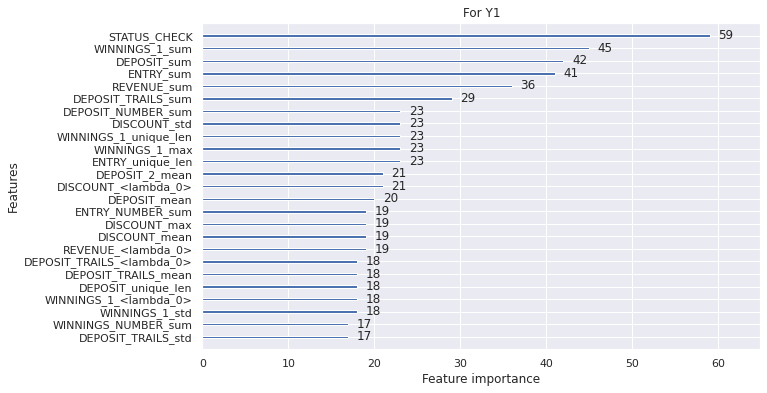

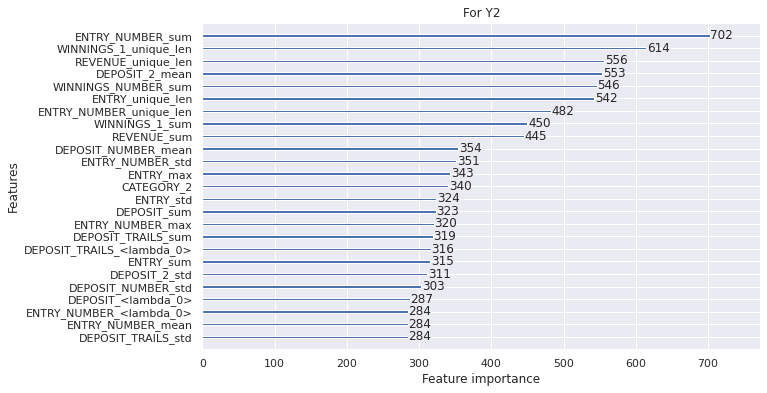

########################################
Training Fold -  2
####################
Training for Y1
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 5.63625	validation's rmse: 5.50168
[400]	training's rmse: 4.7689	validation's rmse: 5.67535
[600]	training's rmse: 4.13478	validation's rmse: 5.81426
[800]	training's rmse: 3.57995	validation's rmse: 5.90292
[1000]	training's rmse: 3.1936	validation's rmse: 5.96397
Early stopping, best iteration is:
[15]	training's rmse: 6.85495	validation's rmse: 5.37741
####################
Training for Y2
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 116.377	validation's rmse: 118.993
[400]	training's rmse: 112.719	validation's rmse: 119.107
[600]	training's rmse: 109.726	validation's rmse: 119.351
[800]	training's rmse: 107.126	validation's rmse: 119.655
[1000]	training's rmse: 104.722	validation's rmse: 119.933
[1200]	training's rmse: 102.504	validation's rmse: 120.181
Early sto

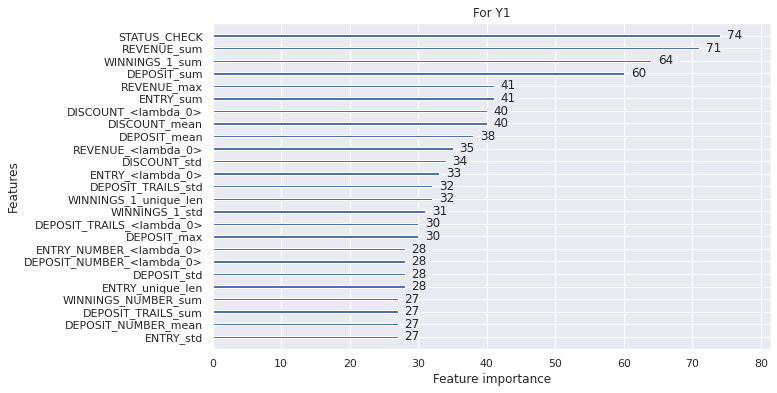

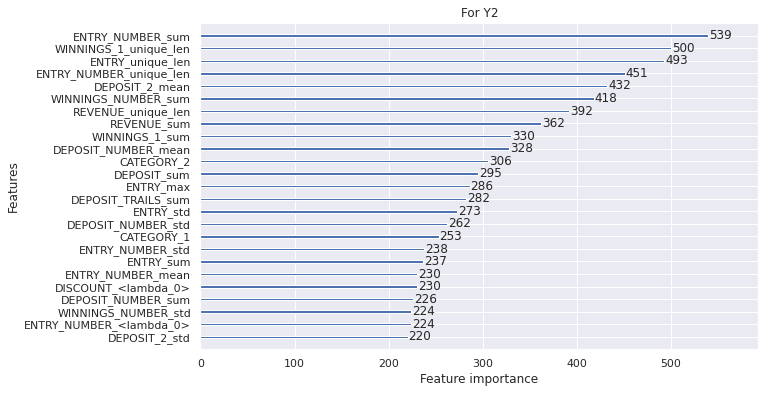

########################################
Training Fold -  3
####################
Training for Y1
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 4.87139	validation's rmse: 8.68759
[400]	training's rmse: 4.07212	validation's rmse: 8.78659
[600]	training's rmse: 3.48026	validation's rmse: 8.76419
[800]	training's rmse: 3.00555	validation's rmse: 8.81134
[1000]	training's rmse: 2.63355	validation's rmse: 8.90284
Early stopping, best iteration is:
[35]	training's rmse: 5.83416	validation's rmse: 8.59064
####################
Training for Y2
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 115.706	validation's rmse: 121.626
[400]	training's rmse: 112.077	validation's rmse: 121.772
[600]	training's rmse: 109.103	validation's rmse: 121.959
[800]	training's rmse: 106.507	validation's rmse: 122.294
[1000]	training's rmse: 104.064	validation's rmse: 122.538
[1200]	training's rmse: 101.904	validation's rmse: 122.818
Early s

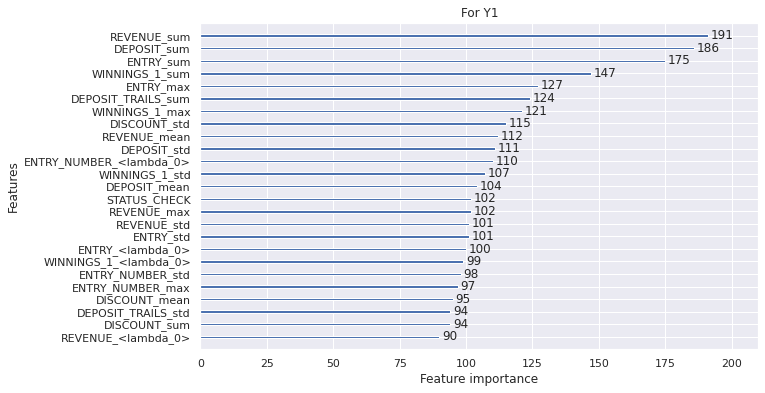

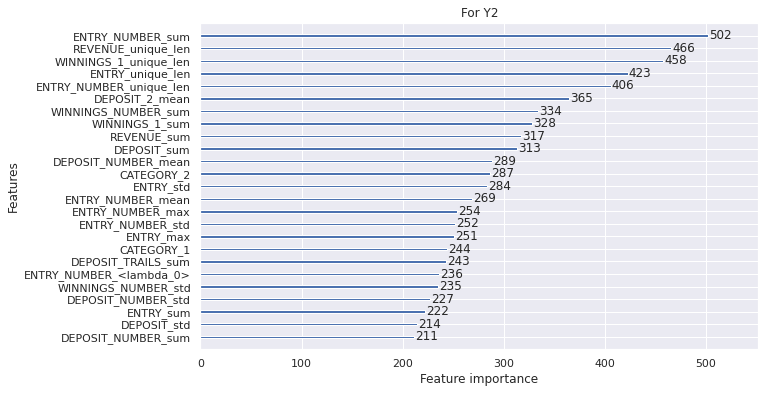

########################################
Training Fold -  4
####################
Training for Y1
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 5.35872	validation's rmse: 7.01298
[400]	training's rmse: 4.57644	validation's rmse: 7.09186
[600]	training's rmse: 3.92472	validation's rmse: 7.17454
[800]	training's rmse: 3.42569	validation's rmse: 7.26385
[1000]	training's rmse: 3.0739	validation's rmse: 7.33938
Early stopping, best iteration is:
[47]	training's rmse: 6.26221	validation's rmse: 6.82569
####################
Training for Y2
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 115.475	validation's rmse: 123.139
[400]	training's rmse: 111.819	validation's rmse: 123.275
[600]	training's rmse: 108.931	validation's rmse: 123.579
[800]	training's rmse: 106.3	validation's rmse: 123.916
[1000]	training's rmse: 103.881	validation's rmse: 124.218
[1200]	training's rmse: 101.649	validation's rmse: 124.426
Early stop

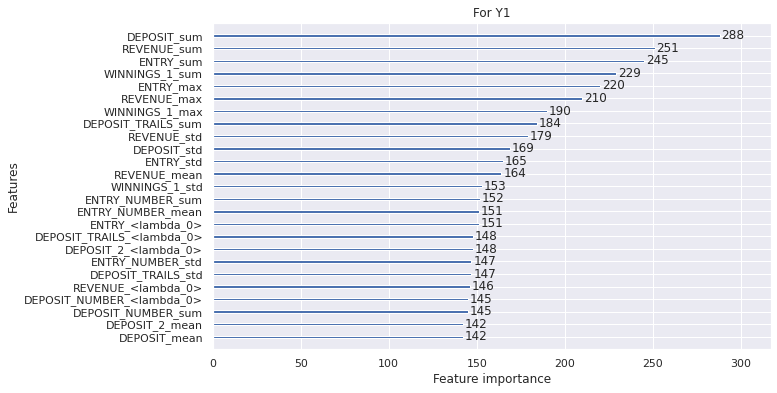

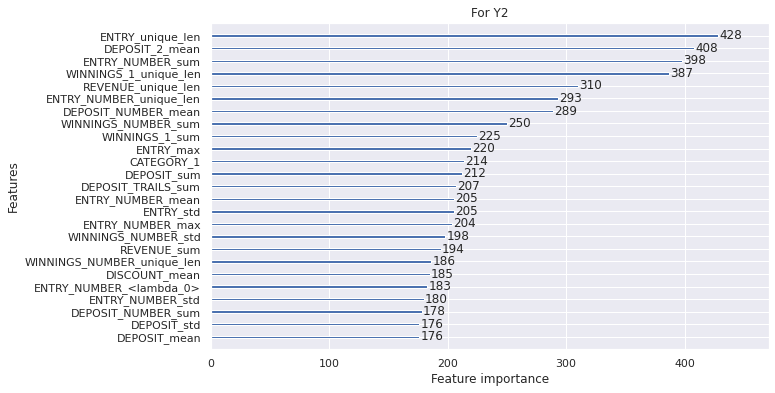

########################################
Training Fold -  5
####################
Training for Y1
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 5.3931	validation's rmse: 6.99183
[400]	training's rmse: 4.6387	validation's rmse: 7.15252
[600]	training's rmse: 4.0002	validation's rmse: 7.20336
[800]	training's rmse: 3.4901	validation's rmse: 7.27034
[1000]	training's rmse: 3.14061	validation's rmse: 7.34107
Early stopping, best iteration is:
[26]	training's rmse: 6.42282	validation's rmse: 6.87638
####################
Training for Y2
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 116.041	validation's rmse: 120.564
[400]	training's rmse: 112.404	validation's rmse: 120.62
[600]	training's rmse: 109.512	validation's rmse: 121.017
[800]	training's rmse: 106.949	validation's rmse: 121.195
[1000]	training's rmse: 104.514	validation's rmse: 121.511
[1200]	training's rmse: 102.239	validation's rmse: 121.884
Early stoppi

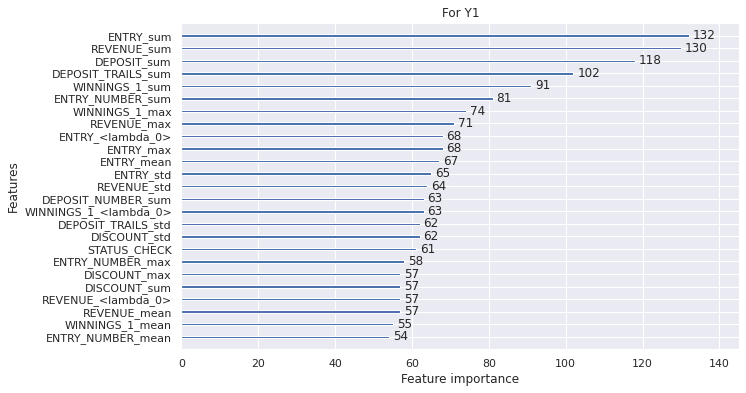

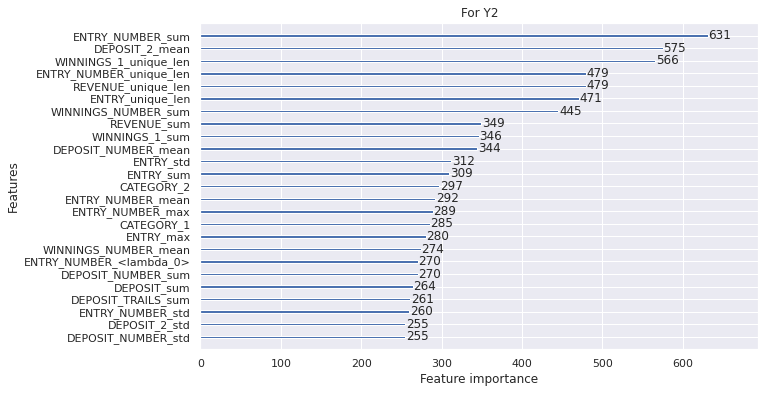

In [34]:
# Prediction arrays
val_pred1 = np.zeros(X.shape[0])
test_pred1 = np.zeros(X_test.shape[0])
val_pred2 = np.zeros(X.shape[0])
test_pred2 = np.zeros(X_test.shape[0])

# K-fold cross valiation
kfold = KFold(n_splits=FOLDS)
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print("#"*40)
    print("Training Fold - ", fold+1)
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val     = X.iloc[val_idx]  , y.iloc[val_idx]

    # create lgb datasets
    train_data1 = lgb.Dataset(X_train, y_train.iloc[:,0], categorical_feature = ["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"])
    val_data1   = lgb.Dataset(X_val,   y_val.iloc[:,0],   categorical_feature = ["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"])
    train_data2 = lgb.Dataset(X_train, y_train.iloc[:,1], categorical_feature = ["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"])
    val_data2   = lgb.Dataset(X_val,   y_val.iloc[:,1],   categorical_feature = ["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"])

    # Train model
    print("#"*20)
    print("Training for Y1")
    model1 = lgb.train(params = lgb_params1,
                     train_set = train_data1,
                     valid_sets = [train_data1, val_data1],
                     num_boost_round = 10000,
                     valid_names=["training", "validation"],
                     early_stopping_rounds = 1000,
                     # callbacks=[neptune_callback],
                     verbose_eval = 200)
    print("#"*20)
    print("Training for Y2")
    model2 = lgb.train(params = lgb_params2,
                     train_set = train_data2,
                     valid_sets = [train_data2, val_data2],
                     num_boost_round = 10000,
                     valid_names=["training", "validation"],
                     early_stopping_rounds = 1000,
                     # callbacks=[neptune_callback],
                     verbose_eval = 200)

    # Plot feature importance
    plot_importance(model1, max_num_features=25, figsize= (10, 6), title="For Y1")
    plot_importance(model2, max_num_features=25, figsize= (10, 6), title="For Y2")
    plt.show()
    
    # Predict validation set
    val_pred1[val_idx] = model1.predict(X_val)
    val_pred2[val_idx] = model2.predict(X_val)
    
    # Predict test set
    test_pred1 += model1.predict(X_test) / FOLDS
    test_pred2 += model2.predict(X_test) / FOLDS

In [35]:
from sklearn.metrics import mean_squared_error as mse
val_rmse = np.mean([np.sqrt(mse(train_["Y1"], val_pred1)), np.sqrt(mse(train_["Y2"], val_pred2))])
print("OOF score:", val_rmse)

OOF score: 63.76267636308777


In [36]:
train_pred_LGB = pd.DataFrame({"Y1_LGB":val_pred1, "Y2_LGB":val_pred2})

In [37]:
test_["Y1_LGB"] = test_pred1
test_["Y2_LGB"] = test_pred2
test_[["UNIQUE_IDENTIFIER", "Y1_LGB", "Y2_LGB"]].to_csv("submission_LGB.csv", index=False)

## CatBoost

In [38]:
FOLDS = 5

In [39]:
print(X.shape, X_test.shape)

(96298, 94) (65242, 94)


In [40]:
from catboost import Pool, CatBoostRegressor

In [41]:
# Prediction arrays
val_pred1 = np.zeros(X.shape[0])
test_pred1 = np.zeros(X_test.shape[0])
val_pred2 = np.zeros(X.shape[0])
test_pred2 = np.zeros(X_test.shape[0])

# K-fold cross valiation
kfold = KFold(n_splits=FOLDS)
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
    print("#"*60)
    print("Training Fold - ", fold+1)
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val     = X.iloc[val_idx]  , y.iloc[val_idx]

    # create lgb datasets
    train_data1 = Pool(X_train, y_train.iloc[:,0], cat_features = ["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"])
    val_data1   = Pool(X_val,   y_val.iloc[:,0],   cat_features = ["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"])
    train_data2 = Pool(X_train, y_train.iloc[:,1], cat_features = ["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"])
    val_data2   = Pool(X_val,   y_val.iloc[:,1],   cat_features = ["STATUS_CHECK", "CATEGORY_1", "CATEGORY_2"])

    # Train model
    print("#"*20)
    print("Training for Y1")
    model1 = CatBoostRegressor(iterations=2000, 
                              depth=3, 
                              learning_rate=0.1, 
                              loss_function='RMSE',
                              eval_metric="RMSE",
                              use_best_model = True,
                              early_stopping_rounds = 1000)
    model1.fit(train_data1, eval_set=val_data1,verbose_eval=200)
    print("#"*20)
    print("Training for Y2")
    model2 = CatBoostRegressor(iterations=7000, 
                              depth=4, 
                              learning_rate=0.05, 
                              loss_function='RMSE',
                              eval_metric="RMSE",
                              use_best_model = True,
                              early_stopping_rounds = 1000)
    model2.fit(train_data2, eval_set=val_data2,verbose_eval=200)

    
    # Predict validation set
    val_pred1[val_idx] = model1.predict(X_val)
    val_pred2[val_idx] = model2.predict(X_val)
    
    # Predict test set
    test_pred1 += model1.predict(X_test) / FOLDS
    test_pred2 += model2.predict(X_test) / FOLDS

############################################################
Training Fold -  1
####################
Training for Y1
0:	learn: 8.5047638	test: 6.8018433	best: 6.8018433 (0)	total: 84.8ms	remaining: 2m 49s
200:	learn: 5.6269752	test: 5.7737708	best: 5.6809936 (66)	total: 6.18s	remaining: 55.3s
400:	learn: 5.2383521	test: 5.8790367	best: 5.6809936 (66)	total: 12s	remaining: 48s
600:	learn: 4.9720799	test: 5.9930193	best: 5.6809936 (66)	total: 18.2s	remaining: 42.4s
800:	learn: 4.7514670	test: 6.0611693	best: 5.6809936 (66)	total: 25s	remaining: 37.4s
1000:	learn: 4.5678587	test: 6.1150740	best: 5.6809936 (66)	total: 30.8s	remaining: 30.7s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 5.680993591
bestIteration = 66

Shrink model to first 67 iterations.
####################
Training for Y2
0:	learn: 181.4443404	test: 176.7170438	best: 176.7170438 (0)	total: 49.4ms	remaining: 5m 45s
200:	learn: 120.9140922	test: 120.4075993	best: 120.4075993 (200)	total: 9.33s	remainin

In [42]:
from sklearn.metrics import mean_squared_error as mse
val_rmse = np.mean([np.sqrt(mse(train_["Y1"], val_pred1)), np.sqrt(mse(train_["Y2"], val_pred2))])
print("OOF score:", val_rmse)

OOF score: 63.747931708837676


In [43]:
train_pred_CAT = pd.DataFrame({"Y1_CAT":val_pred1, "Y2_CAT":val_pred2})

In [44]:
test_["Y1_CAT"] = test_pred1
test_["Y2_CAT"] = test_pred2
test_[["UNIQUE_IDENTIFIER", "Y1_CAT", "Y2_CAT"]].to_csv("submission_CAT.csv", index=False)

# Ensemble

In [45]:
# All three models
sub_NN = pd.read_csv("./submission_NN.csv")
sub_LGB = pd.read_csv("./submission_LGB.csv")
sub_CAT = pd.read_csv("./submission_CAT.csv")
test_["Y1"] = (sub_NN.iloc[:,1] + sub_LGB.iloc[:,1] + sub_CAT.iloc[:,1])/3
test_["Y2"] = (sub_NN.iloc[:,2] + sub_LGB.iloc[:,2]+ sub_CAT.iloc[:,2])/3
test_[["UNIQUE_IDENTIFIER", "Y1", "Y2"]].to_csv("submission.csv", index=False)

In [46]:
# Only boosting models
sub_LGB = pd.read_csv("./submission_LGB.csv")
sub_CAT = pd.read_csv("./submission_CAT.csv")
test_["Y1"] = (sub_LGB.iloc[:,1] + sub_CAT.iloc[:,1])/2
test_["Y2"] = (sub_LGB.iloc[:,2]+ sub_CAT.iloc[:,2])/2
test_[["UNIQUE_IDENTIFIER", "Y1", "Y2"]].to_csv("submission_boost.csv", index=False)

## Random Forest
A Failed attempt!

In [47]:
# from sklearn.ensemble import RandomForestRegressor

# X = pd.concat([train_pred_CAT, train_pred_LGB], axis=1)
# X_test = test_[["Y1_CAT", "Y1_LGB", "Y2_CAT", "Y2_LGB"]]

# print(X.shape, X_test.shape)

# # Prediction arrays
# val_pred1 = np.zeros(X.shape[0])
# test_pred1 = np.zeros(X_test.shape[0])
# val_pred2 = np.zeros(X.shape[0])
# test_pred2 = np.zeros(X_test.shape[0])

# # K-fold cross valiation
# kfold = KFold(n_splits=FOLDS)
# for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
#     print("#"*60)
#     print("Training Fold - ", fold+1)
#     X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#     X_val, y_val     = X.iloc[val_idx]  , y.iloc[val_idx]

#     # create training datasets
#     y_train1 = y_train.iloc[:,0]
#     y_val1   = y_val.iloc[:,0]
#     y_train2 = y_train.iloc[:,1]
#     y_val2   = y_val.iloc[:,1]

#     # Train model
#     print("#"*20)
#     print("Training for Y1")
#     rfr1 = RandomForestRegressor(n_estimators = 1000,
#                             max_depth = 3,
#                            oob_score = True,
#                            n_jobs = -1,
#                            random_state = seed,
#                            max_samples = 0.6)
#     rfr1.fit(X_train, y_train1)
#     print("#"*20)
#     print("Training for Y2")
#     rfr2 = RandomForestRegressor(n_estimators = 2000,
#                             max_depth = 4,
#                            oob_score = True,
#                            n_jobs = -1,
#                            random_state = seed,
#                            max_samples = 0.6)
#     rfr2.fit(X_train, y_train2)

#     # Predict validation set
#     val_pred1[val_idx] = rfr1.predict(X_val)
#     val_pred2[val_idx] = rfr2.predict(X_val)
    
#     # Predict test set
#     test_pred1 += rfr1.predict(X_test) / FOLDS
#     test_pred2 += rfr2.predict(X_test) / FOLDS

# from sklearn.metrics import mean_squared_error as mse
# val_rmse = np.mean([np.sqrt(mse(train_["Y1"], val_pred1)), np.sqrt(mse(train_["Y2"], val_pred2))])
# print("OOF score:", val_rmse)

# test_["Y1_RFR"] = test_pred1
# test_["Y2_RFR"] = test_pred2
# test_[["UNIQUE_IDENTIFIER", "Y1_RFR", "Y2_RFR"]].to_csv("submission_RFR.csv", index=False)